# Python Multiprocessing

I will do my best to not go too crazy here with details.  I promise.  Hopefully.

Ultimately, we want our compute instance to run our code and do some tasks at the same time rather than one, wait, the next, wait, and so on (sequential).

Sounds simple, but there are actually some flavors here:
- Concurrently: tasks overlap but dont necessarily absorb compute at the exact same instance.  Computers with single cores can context switch.  Computers with multiple cores can both context switch and handle multiple sets of contexts at the same time.
- In parallel: tasks actually compute at the exact same time.  Computers with multiple cores can do this when instructed correctly.

Cool, we're done with the description so let's just jump to the how!  

Not so fast!

Tasks! Not all tasks are the same flavor.

**sweet** Sometimes a task is to make a request which in turn waits on a response.  That wait time can be literally waiting on the remote computer or API to respond.  It can also be the CPU waiting while data moves over a network into memory = IO.  

**salty** Other times a task is telling the local computer to do something, like math, which makes the CPU jump for joy.  

These types of task have different needs.  Do we want concurrent or parallel?  We want to manage them concurrently and maximize parallelism!  We are happiest when 99.9% of compute resources are used at all times right?  

You might have heard of multi-threading and be ready to run to town with that idea.  Just `import threading` and go right?
- concurrency means threads are progressing at the same time
- parallelism means threads are computing at the exact same time

> Threading + Python, and in the same process is very tricky because of [GIL](https://docs.python.org/3/glossary.html#term-global-interpreter-lock).  GIL is the party crasher.  He protects objects like dictionaries from concurrent access collisions.  By doing so limits the processing of threads on behalf of Python.  

I promised not too much details but here we are...

> Let me refocus my promise.  I will stick to completely independent tasks.  Not tasks that can go after the same data at the same time (Race) condition.  Not overloading the context switching to create more overhead.  Just pure indepdent tasks.  Promise!

> I promise to focus on atomic single tasks.  Not a chain of tasks with different needs.  We are not developing software here, we are creating an efficient step in our workflow.

Let's talk a bit about multiprocessing.  The tasks I promised to focus on are independent.  By being independent we can give them their own process and not worry about collisions! Just running multiple threads shows we can context switch.  Running multiple processes simoultaneously shows we can make all the CPUs jiggle together. Thats what we want!  

Back to tasks of two flavors!

**sweet** When I want to do lots of requests, like request predictions from a remote API, I want to manage a ton of requests that have some waiting involved.  Lots of concurrency.  Let's call this asynchronous.  We want to launch as many as possible and switch back to the ones that are ready as soon as possible.  We want to go in any order that maximizes our throughput.  

**salty** When I want to do a CPU intensive local process on multiple independent settings I want to multi-process as much as possible.  Saturate all the available CPUS.

---
## Setup

inputs:

In [1]:
EXPERIMENT = 'multi'

packages:

In [2]:
import time
import random
import numpy as np
import pandas as pd

import asyncio
import multiprocessing

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

parameters:

In [3]:
DIR = f'temp/{EXPERIMENT}'

environment:

In [4]:
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Example Task

Create two example tasks:
- a local tasks that computes something locally
    - Here it creates a large data matrix and fits least-squares.
    - Salty!
- a remote tasks that computes something remotely
    - Here it simulates the remote computing by waiting (sleeping) and random amount of time between (0, 2) seconds
    - Sweet!

In [56]:
def local_task(b, n, d):
    task_begin = time.perf_counter()
    
    # do tasks locally: generate data and fit least-squares
    #b = [0.75, 1.88]
    #n = 50000
    #d = 1
    n = int(n)
    x = np.random.rand(n)*10
    y = b[0] + b[1] * x + np.random.normal(0, d, n)
    b_hat = np.linalg.lstsq(np.vstack([np.ones(len(x)), x]).T, y, rcond=None)[0]
    
    task_end = time.perf_counter()
    return task_begin, task_end
    
def remote_task(b, n, d):
    task_begin = time.perf_counter()
    
    # send request to do task remotely (API, etc), simulate by sleeping which uses no resources (like waiting)
    time.sleep(random.random()*2) # wait random time: (0, 2) seconds
    
    task_end = time.perf_counter()
    return task_begin, task_end

In [57]:
local = local_task([0.75, 1.88], 5000000, 1)
print(f'Duration: {local[1] - local[0]} seconds')

Duration: 0.5439769350923598 seconds


In [58]:
remote = remote_task([0.75, 1.88], 5000000, 1)
print(f'Duration: {remote[1] - remote[0]} seconds')

Duration: 1.6154789119027555 seconds


## Run Tasks Sequentially

Run the local and remote tasks multiple times in sequence.  The easy way!
- local tasks, Salty:
    - the local tasks will absorbe compute on each call
    - But.... it may only use a single CPU on a multi-cpu instance
- remote tasks, Sweet:
    - the remote tasks waits, and here it finshes waiting on the result before allowing the next process to start

In [59]:
total_requests = 10

begin = time.perf_counter()
tasks = []
for n in range(total_requests):
    task = local_task([0.75, 1.88], 5000000, 1)
    tasks.append((n, (task[0] - begin, task[1] - begin)))
end = time.perf_counter()

local_tasks = {'timing': tasks, 'timing_range': (begin, end)}

In [70]:
local_tasks

{'timing': [(0, (8.221389725804329e-05, 0.547318680677563)),
  (1, (0.5480113457888365, 1.1134280730038881)),
  (2, (1.1140679749660194, 1.678653271868825)),
  (3, (1.6793156298808753, 2.266573757864535)),
  (4, (2.267248653806746, 2.838440336752683)),
  (5, (2.839140589814633, 3.4030264648608863)),
  (6, (3.4037089366465807, 3.966173430904746)),
  (7, (3.966856102924794, 4.5300017786212265)),
  (8, (4.530663270968944, 5.093002260662615)),
  (9, (5.093704660888761, 5.6580916489474475))],
 'timing_range': (3002033.748933228, 3002039.407997339)}

In [71]:
total_requests = 10

begin = time.perf_counter()
tasks = []
for n in range(total_requests):
    task = remote_task([0.75, 1.88], 5000000, 1)
    tasks.append((n, (task[0] - begin, task[1] - begin)))
end = time.perf_counter()

remote_tasks = {'timing': tasks, 'timing_range': (begin, end)}

In [72]:
remote_tasks

{'timing': [(0, (7.90259800851345e-05, 0.43695846013724804)),
  (1, (0.4369727619923651, 2.2655021199025214)),
  (2, (2.2655155607499182, 3.547890300862491)),
  (3, (3.547903880942613, 4.912672828882933)),
  (4, (4.912685547955334, 6.748503973707557)),
  (5, (6.748518739826977, 8.509522362146527)),
  (6, (8.50953949475661, 9.368454219773412)),
  (7, (9.36846904270351, 10.04948725970462)),
  (8, (10.049499806948006, 11.98955440102145)),
  (9, (11.989572379738092, 12.132571411784738))],
 'timing_range': (3002356.470030507, 3002368.602791158)}

## Visualize Tasks Timeline

In [76]:
def plot_tasks(tasks):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot()
    for task in tasks['timing']:
        ax.add_patch(
            Rectangle(
                (task[1][0], task[0]-.5),
                width = task[1][1] - task[1][0],
                height = 1,
                color = 'green'
            )
        )
    plt.xlim([0, tasks['timing_range'][1]-tasks['timing_range'][0]])
    plt.ylim([
        tasks['timing'][0][0]-0.5,
        tasks['timing'][-1][0]+0.5
    ])
    plt.xlabel("Time (seconds)")
    plt.ylabel("Tasks")
    plt.title(f"Timeline for Executing Tasks")
    plt.show()

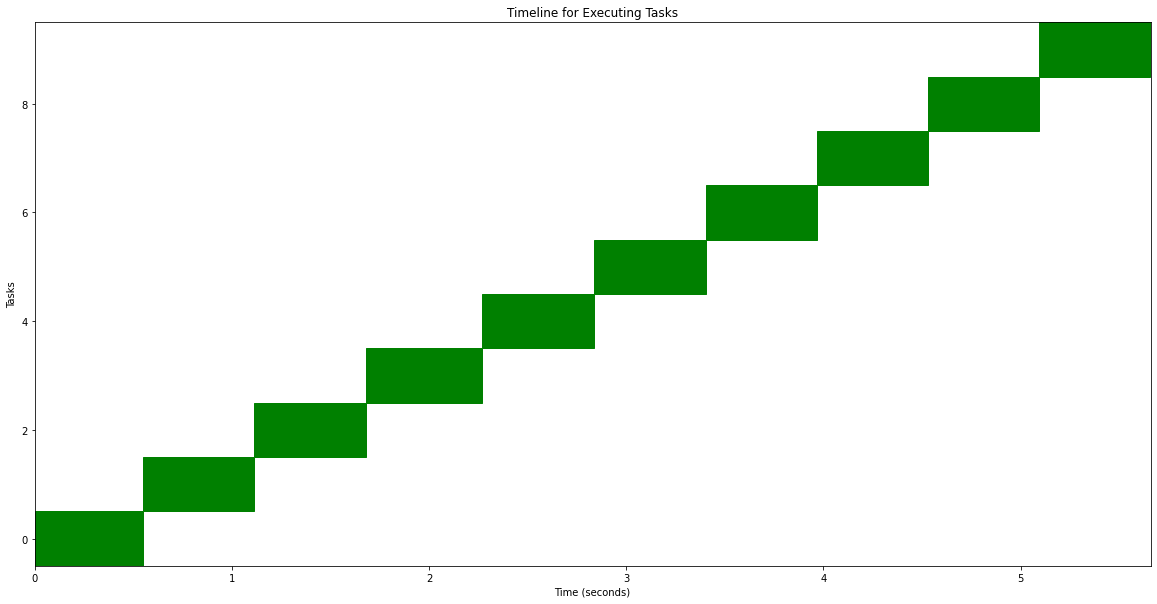

In [77]:
plot_tasks(local_tasks)

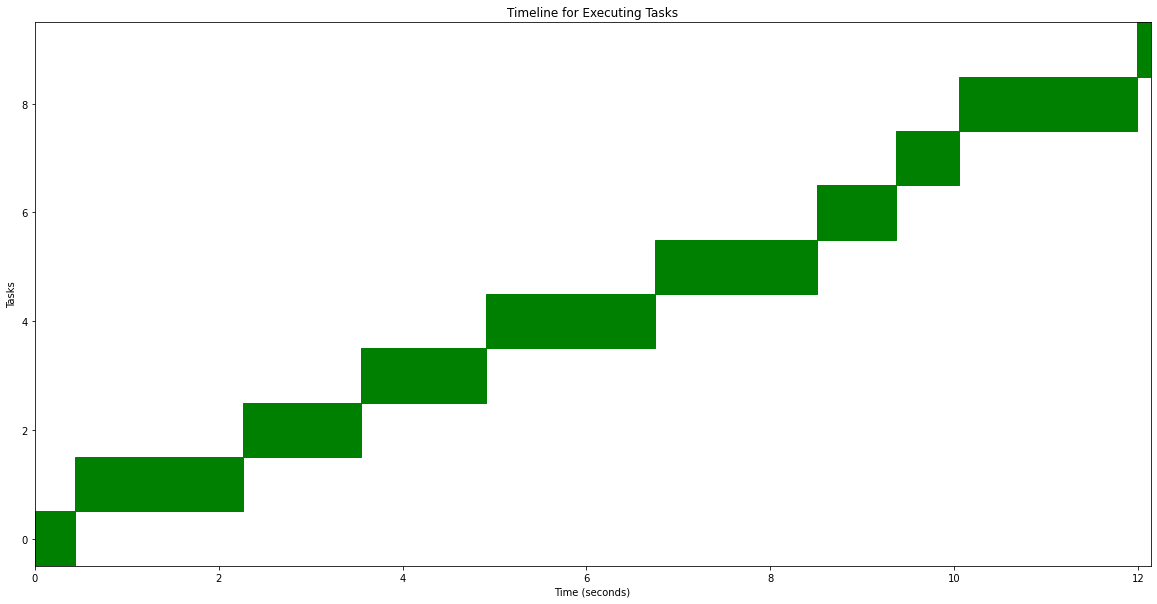

In [78]:
plot_tasks(remote_tasks)

## (Sweet) - Concurrency with Waiting, IO - Remote Processing

Using [asyncio](https://docs.python.org/3/library/asyncio.html) to manage multiple concurrent calls to a function (which may call an API).

The call function needs to be written to be asynchronous.  I don't recommend doing that for our data science workflows.  So why mention this at all?  Because Vertex AI client have async versions!!

What about flooding?  Thats my term for asking for more than the remote system can handle.  We want to limit how many request we have oustanding.  In the example below I do this with `asyncio.Semaphore` which creates a gate keeper monitors aquire and release calls and holds the ceiling at our desired limit.  This can also be great for ramping up calls to an API.

The example below simulates waiting on an API call with a sleep value.  It sleeps a random about of time between 0 and 2 seconds.  Even this call to sleep needs to be an awaitable function and it turns out `asyncio` has a built in `asyncio.sleep` that we use here.

In [107]:
async def run_remote_task(total_requests, concur_requests):
    # create a limit for how many request can be made concurrently
    limit = asyncio.Semaphore(concur_requests)

    async def async_remote_task(t, limit):

        async with limit:
            task_begin = time.perf_counter()
            # send request to do task remotely (API, etc)
            await asyncio.sleep(random.random()*2) # wait (0, 2) seconds
            if limit.locked():
                await asyncio.sleep(.001)

            task_end = time.perf_counter()
        return (t, (task_begin - begin, task_end - begin))

    async def async_runner(total_requests):
        async_tasks = []
        for t in range(1, total_requests + 1):
            async_task = asyncio.create_task(async_remote_task(t, limit))
            async_tasks.append(async_task)

        results = await asyncio.gather(*async_tasks)
        return results

    begin = time.perf_counter()   
    timing = await async_runner(total_requests)
    end = time.perf_counter()
    remote_tasks = {'timing': timing, 'timing_range': (begin, end)}
    return remote_tasks

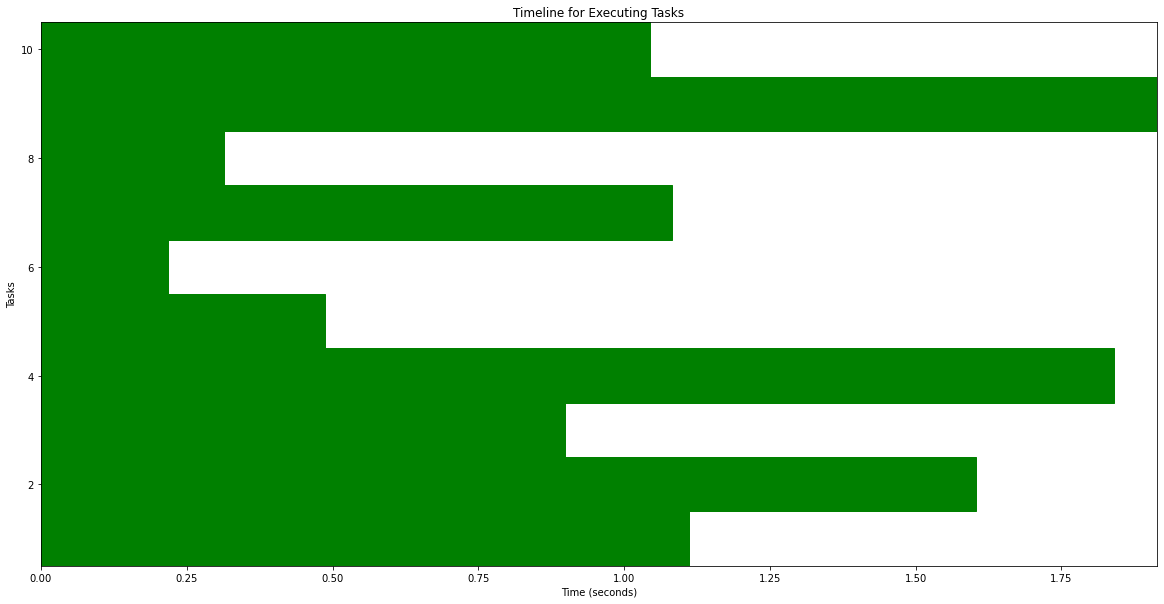

In [108]:
# run 10 with 10 concurrent
remote_tasks = await run_remote_task(10, 10)
plot_tasks(remote_tasks)

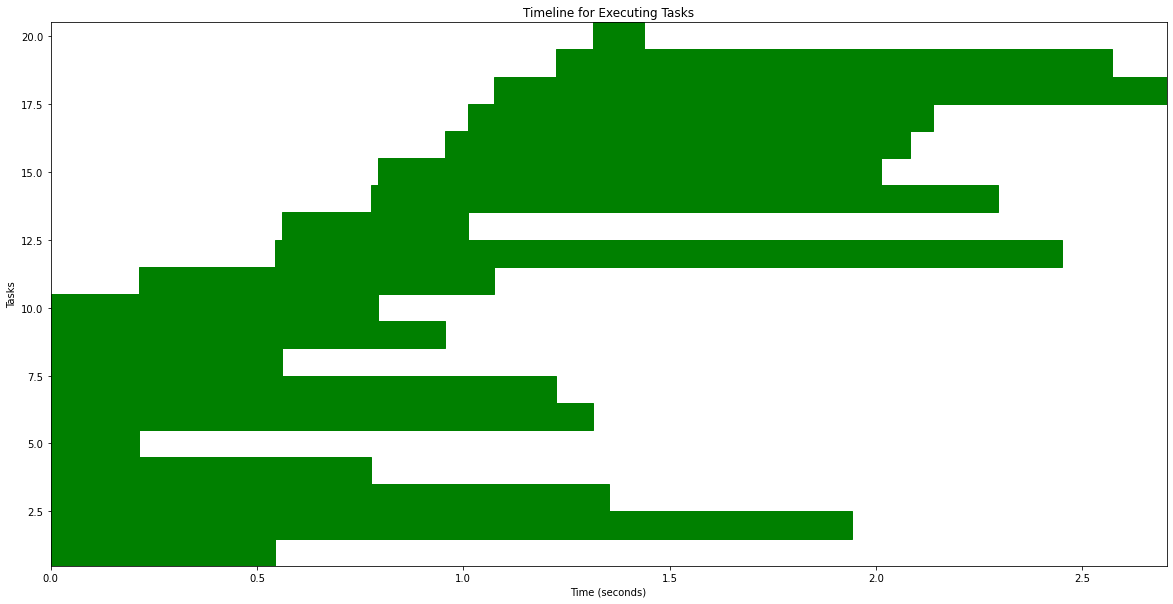

In [109]:
# run 20 with 10 concurrent
remote_tasks = await run_remote_task(20, 10)
plot_tasks(remote_tasks)

## (Salty) - Multiprocessing - Parallel Local Processing

The `local_task` function written above does a CPU intense calculation locally.  In the sequential example it was called multiple times but each call did not commense until the previous one completed.  If this local compute instance has capacity it may be able to handle multiple execution of the function in multiple independent processes = multiprocessing.

In [136]:
import multiprocessing
import tqdm

In [137]:
multiprocessing.cpu_count()

4

In [158]:
total_requests = 10

begin = time.perf_counter()
# make of list of set (list) of inputs for each request.  Here its just the repeat parameter set.
calls = [[[0.75, 1.88], 5000000, 1, begin, i] for i in range(total_requests)]

# make a function that calls the local function, passes inputs
# if the local function only has a single input this is not really needed!
def call_local_task(inputs):
    task = local_task(inputs[0], inputs[1], inputs[2])
    return (inputs[4], (task[0] - inputs[3], task[1] - inputs[3]))

# create a pool, map the list of input sets to the calling function.  Use tqdm to watch progress over input sets.
pool = multiprocessing.Pool(multiprocessing.cpu_count() - 1)
timing = list(
    tqdm.tqdm(
        pool.imap(
            call_local_task,
            calls
        ),
        total = len(calls)
    )
)
pool.close()
pool.join()
end = time.perf_counter()

100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


In [159]:
local_tasks = {'timing': timing, 'timing_range': (begin, end)}

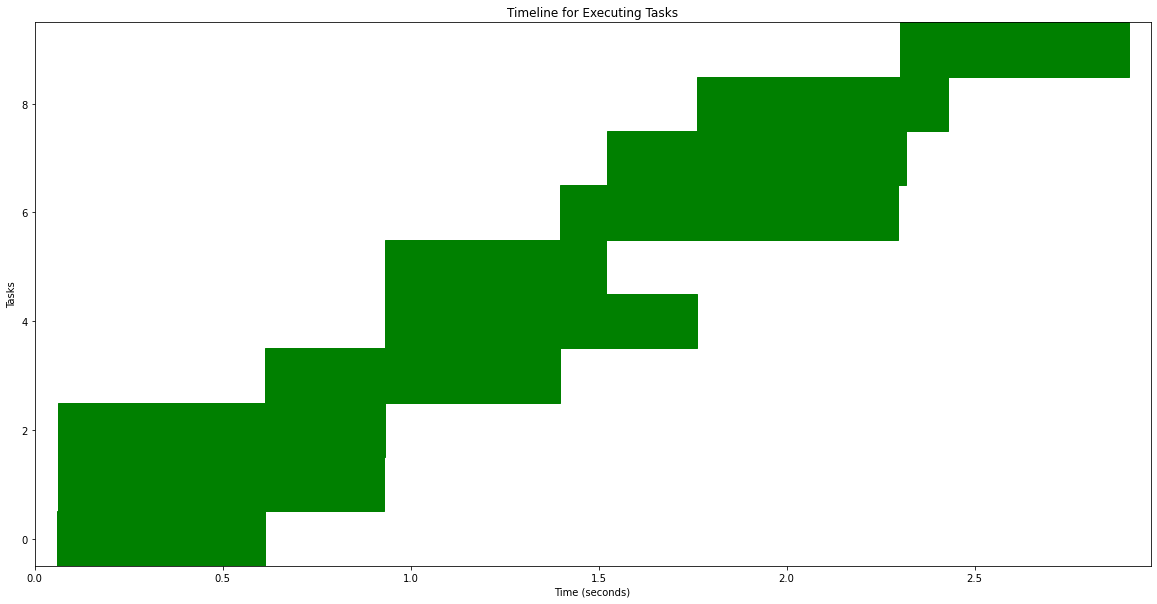

In [160]:
plot_tasks(local_tasks)